# Predicting March Madness winners using automated feature engineering and head to head information

In [121]:
#this is my standard way of handling path issues and shared libraries with Jupyter Notebooks
#Basically just set the path using the folder_name of the project and create any env variables
import sys,os
folder_name="march_madness"
BASE_DIR=os.path.abspath(".").split(folder_name)[0]+folder_name
DATA_ROOT=os.path.join(BASE_DIR,"data")
sys.path.insert(0, DATA_ROOT)

import utils
#use reload to easily reload changes
from importlib import reload
_=reload(utils)
import pandas as pd
np=pd.np
pd.options.display.max_rows=10#So we don't have to always write head
pd.options.display.max_columns=999
from sklearn.ensemble import *
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import featuretools as ft
ft.__version__

'0.6.1'

# Load Data

First build team game logs as the base for building the matchups and team_game entiysets

In [5]:
reload(utils)
team_game_log=utils.build_team_game_log()
team_game_log

,season,DayNum,team_TeamID,team_Score,opp_TeamID,opp_Score,NumOT,team_FGM,team_FGA,team_FGM3,team_FGA3,team_FTM,team_FTA,team_OR,team_DR,team_Ast,team_TO,team_Stl,team_Blk,team_PF,opp_FGM,opp_FGA,opp_FGM3,opp_FGA3,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,game_type,game_index,game_datetime,team_margin,opp_margin,team_wins,opp_wins,team_game_loc,matchup_id,team_season_id,opp_season_id,team_game_index,opp_game_index,game_end,game_PF,game_MOV,opp_FGA2,opp_FGM2,opp_PFP,opp_TSA,opp_TS,opp_FG2_points,opp_FG3_points,opp_FG_points,opp_FG2_points_share_FG,opp_FG2_points_share_points,opp_FG3_points_share_FG,opp_FG3_points_share_points,opp_FG_points_share_FG,opp_FG_points_share_points,opp_FG_points/FT_points,opp_FT_point_share,opp_eFGP,opp_FGP3,opp_FTP,opp_FGP,opp_FGP2,team_FGA2,team_FGM2,team_PFP,team_TSA,team_TS,team_FG2_points,team_FG3_points,team_FG_points,team_FG2_points_share_FG,team_FG2_points_share_points,team_FG3_points_share_FG,team_FG3_points_share_points,team_FG_points_share_FG,team_FG_points_share_points,team_FG_points/FT_points,team_FT_point_share,team_eFGP,team_FGP3,team_FTP,team_FGP,team_FGP2,team_region,team_seed,opp_region,opp_seed,team_is_higher_seed
0,2003,10,1104,68,1328,62,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,regular_season,2003_10_1104_1328,2002-11-14,6,-6,True,False,N,1104_1328,2003_1104,2003_1328,2003_10_1104_1328_1104,2003_10_1104_1328_1328,2002-11-15,42,6,43,20,0.476190,62.68,0.494576,40,6,46,0.869565,0.645161,0.130435,0.096774,1.0,0.741935,2.875000,0.258065,0.433962,0.200000,0.727273,0.415094,0.465116,44,24,0.523810,65.92,0.515777,48,9,57,0.842105,0.705882,0.157895,0.132353,1.0,0.838235,5.181818,0.161765,0.491379,0.214286,0.611111,0.465517,0.545455,Y,10.0,W,1.0,True
1,2003,10,1328,62,1104,68,0,22,53,2,10,16,22,10,22,8,18,9,2,20,27,58,3,14,11,18,14,24,13,23,7,1,22,regular_season,2003_10_1104_1328,2002-11-14,-6,6,False,True,N,1104_1328,2003_1328,2003_1104,2003_10_1104_1328_1328,2003_10_1104_1328_1104,2002-11-15,42,6,44,24,0.523810,65.92,0.515777,48,9,57,0.842105,0.705882,0.157895,0.132353,1.0,0.838235,5.181818,0.161765,0.491379,0.214286,0.611111,0.465517,0.545455,43,20,0.476190,62.68,0.494576,40,6,46,0.869565,0.645161,0.130435,0.096774,1.0,0.741935,2.875000,0.258065,0.433962,0.200000,0.727273,0.415094,0.465116,W,1.0,Y,10.0,False
2,2003,10,1272,70,1393,63,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,regular_season,2003_10_1272_1393,2002-11-14,7,-7,True,False,N,1272_1393,2003_1272,2003_1393,2003_10_1272_1393_1272,2003_10_1272_1393_1393,2002-11-15,34,7,43,18,0.470588,75.80,0.415567,36,18,54,0.666667,0.571429,0.333333,0.285714,1.0,0.857143,6.000000,0.142857,0.402985,0.250000,0.450000,0.358209,0.418605,42,18,0.529412,70.36,0.497442,36,24,60,0.600000,0.514286,0.400000,0.342857,1.0,0.857143,6.000000,0.142857,0.483871,0.400000,0.526316,0.419355,0.428571,Z,7.0,W,3.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166175,2018,152,1276,69,1260,57,0,25,59,7,28,12,18,11,25,8,11,10,2,11,22,51,1,10,12,14,6,26,6,17,5,1,17,march_madness,2018_152_1260_1276,2018-03-31,12,-12,True,False,N,1260_1276,2018_1276,2018_1260,2018_152_1260_1276_1276,2018_152_1260_1276_1260,2018-04-01,28,12,41,21,0.607143,57.16,0.498600,42,3,45,0.933333,0.736842,0.066667,0.052632,1.0,0.789474,3.750000,0.210526,0.441176,0.100000,0.857143,0.431373,0.512195,31,18,0.392857,66.92,0.515541,36,21,57,0.631579,0.521739,0.368421,0.304348,1.0,0.826087,4.750000,0.173913,0.483051,0.250000,0.666667,0.423729,0.580645,Z,3.0,Y,11.0,False
166176,2018,154,1276,62,1437,79,0,24,55,3,23,11,18,6,21,6,10,6,1,20,27,57,10,27,15,20,12,26,7,12,5,3,18,march_ma

In [6]:
matchups_es=utils.load_matchups_entityset(team_game_log)
matchups_es

Entityset: None
  Entities:
    possible_matchups [Rows: 66795, Columns: 3]
    matchup_log [Rows: 83089, Columns: 94]
  Relationships:
    matchup_log.matchup_id -> possible_matchups.matchup_id

For all the statistics below see https://www.basketball-reference.com/about/glossary.html for an idea about names if you are unsure of the abbreviations

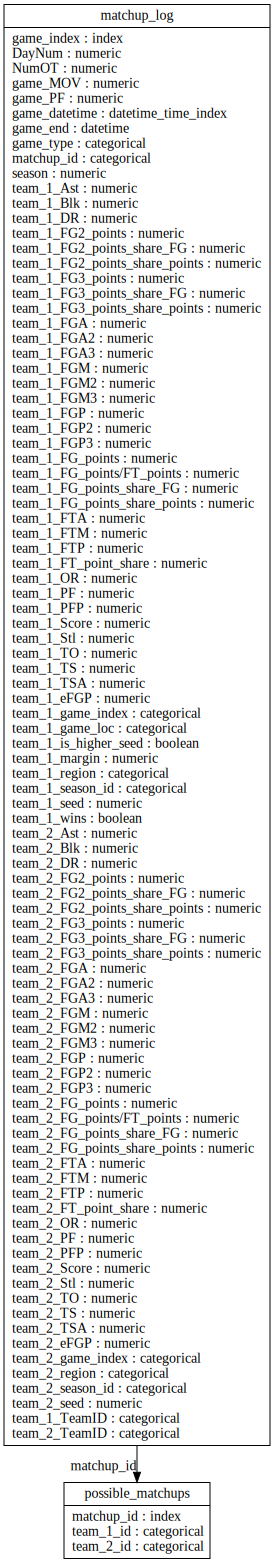

In [7]:
matchups_es.plot()

In [8]:
team_game_logs_es=utils.load_team_game_logs_entityset(team_game_log)
team_game_logs_es

Entityset: None
  Entities:
    team [Rows: 366, Columns: 4]
    team_game_log [Rows: 166178, Columns: 96]
  Relationships:
    team_game_log.team_TeamID -> team.TeamID

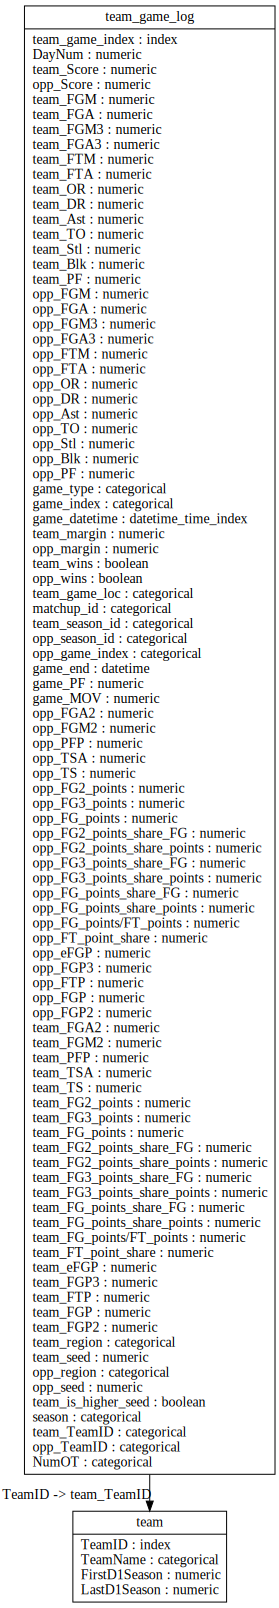

In [9]:
team_game_logs_es.plot()

In [10]:
team_game_logs_es["team_game_log"]["game_type"].interesting_values = ["regular_season", "march_madness"]
team_game_logs_es["team_game_log"]["team_wins"].interesting_values = [False, True]
team_game_logs_es['team_game_log']['team_seed'].interesting_values = list(range(1,17))
team_game_logs_es['team_game_log']['opp_seed'].interesting_values = list(range(1,17))
#regions determine order of teams on a bracket and times of games
team_game_logs_es['team_game_log']['team_region'].interesting_values = ['W', 'X','Y','Z']
team_game_logs_es['team_game_log']['opp_region'].interesting_values = ['W', 'X','Y','Z']

matchups_es["matchup_log"]["game_type"].interesting_values = ["regular_season", "march_madness"]
matchups_es["matchup_log"]["team_1_wins"].interesting_values = [False, True]
matchups_es['matchup_log']['team_1_seed'].interesting_values = list(range(1,17))
matchups_es['matchup_log']['team_2_seed'].interesting_values = list(range(1,17))
matchups_es['matchup_log']['team_1_region'].interesting_values = ['W', 'X','Y','Z']
matchups_es['matchup_log']['team_2_region'].interesting_values = ['W', 'X','Y','Z']

# Make Labels

We'll use tournament start dates to generate the predictions we need for Kaggle. The contest is to predict the outcome between any 2 possible March Madness matchups before the tourney. Only played games will be scored.  

In [11]:
matchup_logs=matchups_es['matchup_log'].df
tourney_starts=matchup_logs[matchup_logs['game_type']=='march_madness'].groupby("season").first()['game_datetime']
tourney_starts

season
2003   2003-03-18
2004   2004-03-16
2005   2005-03-15
          ...    
2016   2016-03-15
2017   2017-03-14
2018   2018-03-13
Name: game_datetime, Length: 16, dtype: datetime64[ns]

In [12]:
tourney_labels=utils.make_tourney_labels(matchups_es, tourney_starts, only_matchups_with_history=False)
tourney_labels

,game_index,time,team_1_wins
0,2003_134_1411_1421,2003-03-18,False
1,2003_136_1112_1436,2003-03-20,True
2,2003_136_1113_1272,2003-03-20,True
...,...,...,...
1045,2018_152_1242_1437,2018-03-31,False
1046,2018_152_1260_1276,2018-03-31,False
1047,2018_154_1276_1437,2018-04-02,False


In [13]:
#We'll use these to create the team_game_log features
tourney_game_labels=utils.make_tourney_labels(team_game_logs_es, tourney_starts)
tourney_game_labels

,team_game_index,time,team_wins
0,2003_134_1411_1421_1411,2003-03-18,False
1,2003_134_1411_1421_1421,2003-03-18,True
2,2003_136_1112_1436_1112,2003-03-20,True
...,...,...,...
2093,2018_152_1260_1276_1276,2018-03-31,True
2094,2018_154_1276_1437_1276,2018-04-02,False
2095,2018_154_1276_1437_1437,2018-04-02,True


## Feature Creation

In [14]:
seed_features=[ft.Feature(team_game_logs_es["team_game_log"]["team_FGP"])]


In [15]:
#time window of march madness games in dataset is 16 years. 
#I left in instead of no training window to be explicit and because it's worth trying a few values to see if decaying trends exists
training_window=ft.Timedelta("16 years")
feature_matrix, features = ft.dfs(target_entity="matchup_log", 
                                  cutoff_time=tourney_labels,
                                  training_window=training_window,
                                  entityset=matchups_es,
                                  cutoff_time_in_index=True,
                                  drop_contains=["matchup_id",
                                              "team_1_game_index","team_1_season_id",
                                             "team_2_game_index","team_2_season_id",
                                              "team_1_TeamID","team_2_TeamID"
                                             ],
                                  seed_features=[ft.Feature(matchups_es["matchup_log"]["team_1_FGP"])],
                                  verbose=True
                                 )
# encode categorical values
matchups_fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)

print("Number of features %s" % len(features_encoded))
matchups_fm_encoded.head(10)

Built 573 features
Elapsed: 02:22 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Number of features 645


,,DayNum,NumOT,game_MOV,game_PF,game_type = march_madness,game_type is unknown,season,team_1_Ast,team_1_Blk,team_1_DR,team_1_FG2_points,team_1_FG2_points_share_FG,team_1_FG2_points_share_points,team_1_FG3_points,team_1_FG3_points_share_FG,team_1_FG3_points_share_points,team_1_FGA,team_1_FGA2,team_1_FGA3,team_1_FGM,team_1_FGM2,team_1_FGM3,team_1_FGP,team_1_FGP2,team_1_FGP3,team_1_FG_points,team_1_FG_points/FT_points,team_1_FG_points_share_FG,team_1_FG_points_share_points,team_1_FTA,team_1_FTM,team_1_FTP,team_1_FT_point_share,team_1_OR,team_1_PF,team_1_PFP,team_1_Score,team_1_Stl,team_1_TO,team_1_TS,team_1_TSA,team_1_eFGP,team_1_game_loc = N,team_1_game_loc is unknown,team_1_is_higher_seed,team_1_margin,team_1_region = Y,team_1_region = X,team_1_region = Z,team_1_region = W,team_1_region is unknown,team_1_seed,team_1_wins,team_2_Ast,team_2_Blk,team_2_DR,team_2_FG2_points,team_2_FG2_points_share_FG,team_2_FG2_points_share_points,team_2_FG3_points,team_2_FG3_points_share_FG,team_2_FG3_points_share_points,team_2_FGA,team_2_FGA2,team_2_FGA3,team_2_FGM,team_2_FGM2,team_2_FGM3,team_2_FGP,team_2_FGP2,team_2_FGP3,team_2_FG_points,team_2_FG_points/FT_points,team_2_FG_points_share_FG,team_2_FG_points_share_points,team_2_FTA,team_2_FTM,team_2_FTP,team_2_FT_point_share,team_2_OR,team_2_PF,team_2_PFP,team_2_Score,team_2_Stl,team_2_TO,team_2_TS,team_2_TSA,team_2_eFGP,team_2_region = Z,team_2_region = W,team_2_region = Y,team_2_region = X,team_2_region is unknown,team_2_seed,DAY(game_datetime) = 18,DAY(game_datetime) = 20,DAY(game_datetime) = 19,DAY(game_datetime) = 17,DAY(game_datetime) = 21,DAY(game_datetime) = 16,DAY(game_datetime) = 22,DAY(game_datetime) = 15,DAY(game_datetime) = 23,DAY(game_datetime) = 24,DAY(game_datetime) is unknown,DAY(game_end) is unknown,YEAR(game_datetime) = 2018,YEAR(game_datetime) = 2017,YEAR(game_datetime) = 2016,YEAR(game_datetime) = 2015,YEAR(game_datetime) = 2014,YEAR(game_datetime) = 2013,YEAR(game_datetime) = 2012,YEAR(game_datetime) = 2011,YEAR(game_datetime) = 2010,YEAR(game_datetime) = 2009,YEAR(game_datetime) is unknown,YEAR(game_end) is unknown,MONTH(game_datetime) = 3,MONTH(game_datetime) = 4,MONTH(game_datetime) is unknown,MONTH(game_end) is unknown,WEEKDAY(game_datetime) = 4,WEEKDAY(game_datetime) = 3,WEEKDAY(game_datetime) = 5,WEEKDAY(game_datetime) = 6,WEEKDAY(game_datetime) = 1,WEEKDAY(game_datetime) = 2,WEEKDAY(game_datetime) = 0,WEEKDAY(game_datetime) is unknown,WEEKDAY(game_end) is unknown,possible_matchups.team_1_id = 1242,possible_matchups.team_1_id = 1181,possible_matchups.team_1_id = 1112,possible_matchups.team_1_id = 1196,possible_matchups.team_1_id = 1211,possible_matchups.team_1_id = 1139,possible_matchups.team_1_id = 1246,possible_matchups.team_1_id = 1163,possible_matchups.team_1_id = 1257,possible_matchups.team_1_id = 1314,possible_matchups.team_1_id is unknown,possible_matchups.team_2_id = 1458,possible_matchups.team_2_id = 1462,possible_matchups.team_2_id = 1437,possible_matchups.team_2_id = 1314,possible_matchups.team_2_id = 1393,possible_matchups.team_2_id = 1452,possible_matchups.team_2_id = 1417,possible_matchups.team_2_id = 1277,possible_matchups.team_2_id = 1400,possible_matchups.team_2_id = 1246,possible_matchups.team_2_id is unknown,possible_matchups.SUM(matchup_log.DayNum),possible_matchups.SUM(matchup_log.NumOT),possible_matchups.SUM(matchup_log.game_MOV),possible_matchups.SUM(matchup_log.game_PF),possible_matchups.SUM(matchup_log.season),possible_matchups.SUM(matchup_log.team_1_Ast),possible_matchups.SUM(matchup_log.team_1_Blk),possible_matchups.SUM(matchup_log.team_1_DR),possible_matchups.SUM(matchup_log.team_1_FG2_points),possible_matchups.SUM(matchup_log.team_1_FG2_points_share_FG),possible_matchups.SUM(matchup_log.team_1_FG2_points_share_points),possible_matchups.SUM(matchup_log.team_1_FG3_points),possible_matchups.SUM(matchup_log.team_1_FG3_points_share_FG),possible_matchups.SUM(matchup_log.team_1_FG3_points_share_points),possible_matchups.SUM(matchup_log.team_1_FGA)

In [16]:
training_window=ft.Timedelta("52 weeks")#more sophisticated approaches could be explored
feature_matrix, features = ft.dfs(target_entity="team_game_log", 
                                  cutoff_time=tourney_game_labels,
                                  training_window=training_window,
                                  entityset=team_game_logs_es,
                                  cutoff_time_in_index=True,
                                  verbose=True,
                                  drop_contains=["matchup_id",
                                              "team_game_index","team_season_id",
                                             "opp_game_index","opp_season_id",
                                              "team_TeamID","opp_TeamID"
                                             ],
                                 )
# encode categorical values
team_game_log_fm_encoded, features_encoded = ft.encode_features(feature_matrix,
                                                  features)

print("Number of features %s" % len(features_encoded))
team_game_log_fm_encoded.head(10)

Built 588 features
Elapsed: 03:38 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks
Number of features 740


,,DayNum,team_Score,opp_Score,team_FGM,team_FGA,team_FGM3,team_FGA3,team_FTM,team_FTA,team_OR,team_DR,team_Ast,team_TO,team_Stl,team_Blk,team_PF,opp_FGM,opp_FGA,opp_FGM3,opp_FGA3,opp_FTM,opp_FTA,opp_OR,opp_DR,opp_Ast,opp_TO,opp_Stl,opp_Blk,opp_PF,game_type = march_madness,game_type is unknown,game_index = 2018_154_1276_1437,game_index = 2018_152_1260_1276,game_index = 2018_152_1242_1437,game_index = 2018_146_1403_1437,game_index = 2018_146_1181_1242,game_index = 2018_145_1243_1260,game_index = 2018_145_1199_1276,game_index = 2018_144_1437_1452,game_index = 2018_144_1345_1403,game_index = 2018_144_1181_1393,game_index is unknown,team_margin,opp_margin,team_wins,opp_wins,team_game_loc = N,team_game_loc is unknown,game_PF,game_MOV,opp_FGA2,opp_FGM2,opp_PFP,opp_TSA,opp_TS,opp_FG2_points,opp_FG3_points,opp_FG_points,opp_FG2_points_share_FG,opp_FG2_points_share_points,opp_FG3_points_share_FG,opp_FG3_points_share_points,opp_FG_points_share_FG,opp_FG_points_share_points,opp_FG_points/FT_points,opp_FT_point_share,opp_eFGP,opp_FGP3,opp_FTP,opp_FGP,opp_FGP2,team_FGA2,team_FGM2,team_PFP,team_TSA,team_TS,team_FG2_points,team_FG3_points,team_FG_points,team_FG2_points_share_FG,team_FG2_points_share_points,team_FG3_points_share_FG,team_FG3_points_share_points,team_FG_points_share_FG,team_FG_points_share_points,team_FG_points/FT_points,team_FT_point_share,team_eFGP,team_FGP3,team_FTP,team_FGP,team_FGP2,team_region = Y,team_region = Z,team_region = X,team_region = W,team_region is unknown,team_seed,opp_region = Y,opp_region = Z,opp_region = X,opp_region = W,opp_region is unknown,opp_seed,team_is_higher_seed,season = 2018,season = 2017,season = 2016,season = 2015,season = 2014,season = 2013,season = 2012,season = 2011,season = 2010,season = 2009,season is unknown,NumOT is unknown,DAY(game_datetime) = 18,DAY(game_datetime) = 20,DAY(game_datetime) = 19,DAY(game_datetime) = 17,DAY(game_datetime) = 21,DAY(game_datetime) = 16,DAY(game_datetime) = 22,DAY(game_datetime) = 15,DAY(game_datetime) = 23,DAY(game_datetime) = 24,DAY(game_datetime) is unknown,DAY(game_end) is unknown,YEAR(game_datetime) = 2018,YEAR(game_datetime) = 2017,YEAR(game_datetime) = 2016,YEAR(game_datetime) = 2015,YEAR(game_datetime) = 2014,YEAR(game_datetime) = 2013,YEAR(game_datetime) = 2012,YEAR(game_datetime) = 2011,YEAR(game_datetime) = 2010,YEAR(game_datetime) = 2009,YEAR(game_datetime) is unknown,YEAR(game_end) is unknown,MONTH(game_datetime) = 3,MONTH(game_datetime) = 4,MONTH(game_datetime) is unknown,MONTH(game_end) is unknown,WEEKDAY(game_datetime) = 4,WEEKDAY(game_datetime) = 3,WEEKDAY(game_datetime) = 5,WEEKDAY(game_datetime) = 6,WEEKDAY(game_datetime) = 1,WEEKDAY(game_datetime) = 2,WEEKDAY(game_datetime) = 0,WEEKDAY(game_datetime) is unknown,WEEKDAY(game_end) is unknown,team.TeamName = Kansas,team.TeamName = North Carolina,team.TeamName = Kentucky,team.TeamName = Duke,team.TeamName = Michigan St,team.TeamName = Wisconsin,team.TeamName = Florida,team.TeamName = Louisville,team.TeamName = Gonzaga,team.TeamName = Syracuse,team.TeamName is unknown,team.FirstD1Season,team.LastD1Season,team.SUM(team_game_log.DayNum),team.SUM(team_game_log.team_Score),team.SUM(team_game_log.opp_Score),team.SUM(team_game_log.team_FGM),team.SUM(team_game_log.team_FGA),team.SUM(team_game_log.team_FGM3),team.SUM(team_game_log.team_FGA3),team.SUM(team_game_log.team_FTM),team.SUM(team_game_log.team_FTA),team.SUM(team_game_log.team_OR),team.SUM(team_game_log.team_DR),team.SUM(team_game_log.team_Ast),team.SUM(team_game_log.team_TO),team.SUM(team_game_log.team_Stl),team.SUM(team_game_log.team_Blk),team.SUM(team_game_log.team_PF),team.SUM(team_game_log.opp_FGM),team.SUM(team_game_log.opp_FGA),team.SUM(team_game_log.opp_FGM3),team.SUM(team_game_log.opp_FGA3),team.SUM(team_game_log.opp_FTM),team.SUM(team_game_log.opp_FTA),team.SUM(team_game_log.opp_OR),team.SUM(team_game_log.opp_DR),team.SUM(team_game_log.opp_Ast),team.SUM(team_game_log.opp_TO),team.SUM(team_game_log.opp_Stl),team.SUM(team_game_log.opp_Blk)

In [18]:
reload(utils)
#this merge uses raw pandas data. In the past I've had issues trying to rename features and thought this would be simpler
fm_encoded=utils.merge_matchups_and_team_game_log_features(matchups_fm_encoded, team_game_log_fm_encoded)
fm_encoded.head()

,game_index,time,DayNum,NumOT,game_MOV,game_PF,game_type = march_madness,game_type is unknown,season,team_1_Ast,team_1_Blk,team_1_DR,team_1_FG2_points,team_1_FG2_points_share_FG,team_1_FG2_points_share_points,team_1_FG3_points,team_1_FG3_points_share_FG,team_1_FG3_points_share_points,team_1_FGA,team_1_FGA2,team_1_FGA3,team_1_FGM,team_1_FGM2,team_1_FGM3,team_1_FGP,team_1_FGP2,team_1_FGP3,team_1_FG_points,team_1_FG_points/FT_points,team_1_FG_points_share_FG,team_1_FG_points_share_points,team_1_FTA,team_1_FTM,team_1_FTP,team_1_FT_point_share,team_1_OR,team_1_PF,team_1_PFP,team_1_Score,team_1_Stl,team_1_TO,team_1_TS,team_1_TSA,team_1_eFGP,team_1_game_loc = N,team_1_game_loc is unknown,team_1_is_higher_seed_matchup,team_1_margin,team_1_region = Y,team_1_region = X,team_1_region = Z,team_1_region = W,team_1_region is unknown,team_1_seed_matchup,team_1_wins,team_2_Ast,team_2_Blk,team_2_DR,team_2_FG2_points,team_2_FG2_points_share_FG,team_2_FG2_points_share_points,team_2_FG3_points,team_2_FG3_points_share_FG,team_2_FG3_points_share_points,team_2_FGA,team_2_FGA2,team_2_FGA3,team_2_FGM,team_2_FGM2,team_2_FGM3,team_2_FGP,team_2_FGP2,team_2_FGP3,team_2_FG_points,team_2_FG_points/FT_points,team_2_FG_points_share_FG,team_2_FG_points_share_points,team_2_FTA,team_2_FTM,team_2_FTP,team_2_FT_point_share,team_2_OR,team_2_PF,team_2_PFP,team_2_Score,team_2_Stl,team_2_TO,team_2_TS,team_2_TSA,team_2_eFGP,team_2_region = Z,team_2_region = W,team_2_region = Y,team_2_region = X,team_2_region is unknown,team_2_seed_matchup,DAY(game_datetime) = 18,DAY(game_datetime) = 20,DAY(game_datetime) = 19,DAY(game_datetime) = 17,DAY(game_datetime) = 21,DAY(game_datetime) = 16,DAY(game_datetime) = 22,DAY(game_datetime) = 15,DAY(game_datetime) = 23,DAY(game_datetime) = 24,DAY(game_datetime) is unknown,DAY(game_end) is unknown,YEAR(game_datetime) = 2018,YEAR(game_datetime) = 2017,YEAR(game_datetime) = 2016,YEAR(game_datetime) = 2015,YEAR(game_datetime) = 2014,YEAR(game_datetime) = 2013,YEAR(game_datetime) = 2012,YEAR(game_datetime) = 2011,YEAR(game_datetime) = 2010,YEAR(game_datetime) = 2009,YEAR(game_datetime) is unknown,YEAR(game_end) is unknown,MONTH(game_datetime) = 3,MONTH(game_datetime) = 4,MONTH(game_datetime) is unknown,MONTH(game_end) is unknown,WEEKDAY(game_datetime) = 4,WEEKDAY(game_datetime) = 3,WEEKDAY(game_datetime) = 5,WEEKDAY(game_datetime) = 6,WEEKDAY(game_datetime) = 1,WEEKDAY(game_datetime) = 2,WEEKDAY(game_datetime) = 0,WEEKDAY(game_datetime) is unknown,WEEKDAY(game_end) is unknown,possible_matchups.team_1_id = 1242,possible_matchups.team_1_id = 1181,possible_matchups.team_1_id = 1112,possible_matchups.team_1_id = 1196,possible_matchups.team_1_id = 1211,possible_matchups.team_1_id = 1139,possible_matchups.team_1_id = 1246,possible_matchups.team_1_id = 1163,possible_matchups.team_1_id = 1257,possible_matchups.team_1_id = 1314,possible_matchups.team_1_id is unknown,possible_matchups.team_2_id = 1458,possible_matchups.team_2_id = 1462,possible_matchups.team_2_id = 1437,possible_matchups.team_2_id = 1314,possible_matchups.team_2_id = 1393,possible_matchups.team_2_id = 1452,possible_matchups.team_2_id = 1417,possible_matchups.team_2_id = 1277,possible_matchups.team_2_id = 1400,possible_matchups.team_2_id = 1246,possible_matchups.team_2_id is unknown,possible_matchups.SUM(matchup_log.DayNum),possible_matchups.SUM(matchup_log.NumOT),possible_matchups.SUM(matchup_log.game_MOV),possible_matchups.SUM(matchup_log.game_PF),possible_matchups.SUM(matchup_log.season),possible_matchups.SUM(matchup_log.team_1_Ast),possible_matchups.SUM(matchup_log.team_1_Blk),possible_matchups.SUM(matchup_log.team_1_DR),possible_matchups.SUM(matchup_log.team_1_FG2_points),possible_matchups.SUM(matchup_log.team_1_FG2_points_share_FG),possible_matchups.SUM(matchup_log.team_1_FG2_points_share_points),possible_matchups.SUM(matchup_log.team_1_FG3_points),possible_matchups.SUM(matchup_log.team_1_FG3_points_share_FG),possible_matchups.SUM(matchup_log.team_1_FG3_points_share_points),possib

# Machine Learning

I found using fm_encoded and features_encoded with feature selection a little tricky compared to using the pandas columns so I didn't follow the example https://github.com/Featuretools/predict-next-purchase/blob/master/Tutorial.ipynb exactly

I used the fm_encoded matrix directly and used the raw pandas columns instead

In [19]:
reload(utils)
X,y=utils.transform_to_Xy(fm_encoded, tourney_labels)
X

DayNum  NumOT  game_MOV  game_PF  game_type = march_madness  \
0        134    0.0       0.0      0.0                          1   
1        136    0.0       0.0      0.0                          1   
2        136    0.0       0.0      0.0                          1   
...      ...    ...       ...      ...                        ...   
1045     152    0.0       0.0      0.0                          1   
1046     152    0.0       0.0      0.0                          1   
1047     154    0.0       0.0      0.0                          1   

      game_type is unknown  season  team_1_Ast  team_1_Blk  team_1_DR  \
0                        0    2003         0.0         0.0        0.0   
1                        0    2003         0.0         0.0        0.0   
2                        0    2003         0.0         0.0        0.0   
...                    ...     ...         ...         ...        ...   
1045                     0    2018         0.0         0.0        0.0   
1046                     0    2018         0.0         0.0        0.0   
1047                     0    2018         0.0         0.0        0.0   

      team_1_FG2_points  team_1_FG2_points_share_FG  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
...                 ...                         ...   
1045                0.0                         0.0   
1046                0.0                         0.0   
1047                0.0                         0.0   

      team_1_FG2_points_share_points  team_1_FG3_points  \
0                                0.0                0.0   
1                                0.0                0.0   
2                                0.0                0.0   
...                              ...                ...   
1045                             0.0                0.0   
1046                             0.0                0.0   
1047                             0.0                0.0   

      team_1_FG3_points_share_FG  team_1_FG3_points_share_points  team_1_FGA  \
0                            0.0                             0.0         0.0   
1                            0.0                             0.0         0.0   
2                            0.0                             0.0         0.0   
...                          ...                             ...         ...   
1045                         0.0                             0.0         0.0   
1046                         0.0                             0.0         0.0   
1047                         0.0                             0.0         0.0   

      team_1_FGA2  team_1_FGA3  team_1_FGM  team_1_FGM2  team_1_FGM3  \
0             0.0          0.0         0.0          0.0          0.0   
1             0.0          0.0         0.0          0.0          0.0   
2             0.0          0.0         0.0          0.0          0.0   
...           ...          ...         ...          ...          ...   
1045          0.0          0.0         0.0          0.0          0.0   
1046          0.0          0.0         0.0          0.0          0.0   
1047          0.0          0.0         0.0          0.0          0.0   

      team_1_FGP  team_1_FGP2  team_1_FGP3  team_1_FG_points  \
0            0.0          0.0          0.0               0.0   
1            0.0          0.0          0.0               0.0   
2            0.0          0.0          0.0               0.0   
...          ...          ...          ...               ...   
1045         0.0          0.0          0.0               0.0   
1046         0.0          0.0          0.0               0.0   
1047         0.0          0.0          0.0               0.0   

      team_1_FG_points/FT_points  team_1_FG_points_share_FG  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0  

## Baseline Using Basic Seeds

In [123]:
baseline_features=["team_1_seed_matchup","team_2_seed_matchup","team_1_is_higher_seed_matchup"]
utils.evaluate_features(X[baseline_features],y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished


AUC 0.75 +/- 0.01


In [124]:
baseline_clf = utils.evaluate_model(X[baseline_features],y)
top_features = utils.feature_importances(baseline_clf, X[baseline_features].columns, n=20)

Log Loss
TRAIN: 0.5310336921529718
TEST: 0.5832455562006558

Accuracy
TRAIN: 0.7251908396946565
TEST: 0.6927480916030534

1: Feature: team_1_seed_matchup, 0.395
2: Feature: team_1_is_higher_seed_matchup, 0.343
3: Feature: team_2_seed_matchup, 0.263


In [125]:
pd.Series(baseline_clf.predict_proba(X[baseline_features])[:,1]).describe()

count    1048.000000
mean        0.480719
std         0.231875
min         0.080132
25%         0.318020
50%         0.509559
75%         0.696447
max         0.833375
dtype: float64

## All features

In [127]:
utils.evaluate_features(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s finished


AUC 0.78 +/- 0.01


# feature selection

I used [this](https://github.com/Featuretools/Automated-Manual-Comparison/blob/master/Retail%20Spending/notebooks/utils.py) as a starting point. Running RFECV with the 1000+ features was too much so we'll eliminate highly corrleated features and low information features

In [130]:
reload(utils)
X,y=utils.transform_to_Xy(fm_encoded, tourney_labels)
utils.evaluate_features(X, y)
clf=utils.evaluate_model(X,y)
pd.Series(clf.predict_proba(X)[:,1]).describe()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s finished


AUC 0.77 +/- 0.01
Log Loss
TRAIN: 0.48654744327869875
TEST: 0.5931361897524539

Accuracy
TRAIN: 0.8091603053435115
TEST: 0.6927480916030534



count    1048.000000
mean        0.469621
std         0.174683
min         0.130788
25%         0.328893
50%         0.474165
75%         0.618373
max         0.822249
dtype: float64

In [111]:

X=utils.feature_selection(X, correlation_threshold=.95)
utils.evaluate_features(X, y)
utils.evaluate_model(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s finished


AUC 0.77 +/- 0.01
Log Loss
TRAIN: 0.48404291143455175
TEST: 0.5881542613668487

Accuracy
TRAIN: 0.8053435114503816
TEST: 0.6984732824427481

Original shape:  (1048, 2033)
0 missing columns with threshold: 90.
299 zero variance columns.
595 collinear columns removed with threshold: 0.95.
Total columns removed:  894
Shape after feature selection: (1048, 1139).


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s finished


AUC 0.77 +/- 0.01
Log Loss
TRAIN: 0.4960901480643845
TEST: 0.6008923988572477

Accuracy
TRAIN: 0.8377862595419847
TEST: 0.6946564885496184



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [131]:
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
param_grid = {"max_depth": [2,3,4,5,6,7],
              "max_features": [3,4,5,7,20],
              "min_samples_split": [2, 3,5,7],
              "n_estimators": [200,400]
             }

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, scoring=["neg_log_loss","roc_auc"],refit="neg_log_loss",n_jobs=-1)
grid_search.fit(X, y)
grid_search.best_params_,grid_search.best_score_ 

({'max_depth': 7,
  'max_features': 20,
  'min_samples_split': 3,
  'n_estimators': 200},
 -0.5787553087548126)

In [132]:
reload(utils)

<module 'utils' from 'C:\\Users\\MatteoHoch\\Documents\\projects\\freelance\\upwork\\feature_labs\\march_madness\\notebooks\\utils.py'>

In [141]:
X[seed_cols]

,team_1_is_higher_seed_matchup,team_1_seed_matchup,team_2_seed_matchup,possible_matchups.SUM(matchup_log.team_1_seed),possible_matchups.SUM(matchup_log.team_2_seed),possible_matchups.STD(matchup_log.team_1_seed),possible_matchups.STD(matchup_log.team_2_seed),possible_matchups.MAX(matchup_log.team_1_seed),possible_matchups.MAX(matchup_log.team_2_seed),possible_matchups.SKEW(matchup_log.team_1_seed),possible_matchups.SKEW(matchup_log.team_2_seed),possible_matchups.MIN(matchup_log.team_1_seed),possible_matchups.MIN(matchup_log.team_2_seed),possible_matchups.MEAN(matchup_log.team_1_seed),possible_matchups.MEAN(matchup_log.team_2_seed),possible_matchups.PERCENT_TRUE(matchup_log.team_1_is_higher_seed),opp_seed_tgm_team,team.MAX(team_game_log.opp_seed)_tgm_team,team.MAX(team_game_log.team_seed)_tgm_team,team.MEAN(team_game_log.opp_seed)_tgm_team,team.MEAN(team_game_log.team_seed)_tgm_team,team.MIN(team_game_log.opp_seed)_tgm_team,team.MIN(team_game_log.team_seed)_tgm_team,team.PERCENT_TRUE(team_game_log.team_is_higher_seed)_tgm_team,team.SKEW(team_game_log.opp_seed)_tgm_team,team.SKEW(team_game_log.team_seed)_tgm_team,team.STD(team_game_log.opp_seed)_tgm_team,team.STD(team_game_log.team_seed)_tgm_team,team.SUM(team_game_log.opp_seed)_tgm_team,team.SUM(team_game_log.team_seed)_tgm_team,team_is_higher_seed_tgm_team,team_seed_tgm_team,opp_seed_tgm_opp,team.MAX(team_game_log.opp_seed)_tgm_opp,team.MAX(team_game_log.team_seed)_tgm_opp,team.MEAN(team_game_log.opp_seed)_tgm_opp,team.MEAN(team_game_log.team_seed)_tgm_opp,team.MIN(team_game_log.opp_seed)_tgm_opp,team.MIN(team_game_log.team_seed)_tgm_opp,team.PERCENT_TRUE(team_game_log.team_is_higher_seed)_tgm_opp,team.SKEW(team_game_log.opp_seed)_tgm_opp,team.SKEW(team_game_log.team_seed)_tgm_opp,team.STD(team_game_log.opp_seed)_tgm_opp,team.STD(team_game_log.team_seed)_tgm_opp,team.SUM(team_game_log.opp_seed)_tgm_opp,team.SUM(team_game_log.team_seed)_tgm_opp,team_is_higher_seed_tgm_opp,team_seed_tgm_opp
0,False,17.0,18.0,17.0,18.0,0.000000,0.000000,17.0,18.0,0.000000,0.000000,17.0,18.0,17.0,18.000000,0.0,18.0,18.0,17.0,11.500000,17.0,5.0,17.0,0.032258,0.121897,0.0,9.192388,0.0,23.0,527.0,False,17.0,17.0,17.0,18.0,8.714286,18.0,1.0,18.0,0.233333,0.121897,0.0,6.550173,0.0,61.0,540.0,True,18.0
1,False,1.0,16.0,1.0,16.0,0.000000,0.000000,1.0,16.0,0.000000,0.000000,1.0,16.0,1.0,16.000000,0.0,16.0,16.0,1.0,7.692308,1.0,1.0,1.0,0.000000,0.214725,0.0,4.210792,0.0,100.0,29.0,False,1.0,1.0,15.0,16.0,8.000000,16.0,1.0,16.0,0.066667,0.214725,0.0,9.899495,0.0,16.0,480.0,True,16.0
2,True,10.0,7.0,10.0,7.0,0.000000,0.000000,10.0,7.0,0.000000,0.000000,10.0,7.0,10.0,7.000000,1.0,7.0,12.0,10.0,6.466667,10.0,1.0,10.0,0.466667,-0.584714,0.0,3.419830,0.0,97.0,300.0,True,10.0,10.0,13.0,7.0,6.500000,7.0,3.0,7.0,0.166667,0.987133,0.0,3.545621,0.0,52.0,210.0,False,7.0
3,True,12.0,5.0,12.0,5.0,0.000000,0.000000,12.0,5.0,0.000000,0.000000,12.0,5.0,12.0,5.000000,1.0,5.0,15.0,12.0,10.583333,12.0,5.0,12.0,0.187500,-0.361608,0.0,3.579191,0.0,127.0,384.0,True,12.0,12.0,18.0,5.0,6.777778,5.0,1.0,5.0,0.161290,0.956025,0.0,6.437736,0.0,61.0,155.0,False,5.0
4,True,11.0,6.0,11.0,6.0,0.000000,0.000000,11.0,6.0,0.000000,0.000000,11.0,6.0,11.0,6.000000,1.0,6.0,6.0,11.0,6.000000,11.0,6.0,11.0,0.033333,-0.660505,0.0,4.105745,0.0,6.0,330.0,True,11.0,11.0,16.0,6.0,10.000000,6.0,3.0,6.0,0.058824,-0.660505,0.0,4.105745,0.0,80.0,204.0,False,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,True,2.0,1.0,12.0,8.0,0.547723,0.547723,3.0,2.0,0.608581,-0.608581,2.0,1.0,2.4,1.600000,0.8,1.0,15.0,2.0,6.666667,2.0,1.0,2.0,0.054054,0.345728,0.0,4.352146,0.0,120.0,74.0,True,2.0,2.0,18.0,1.0,8.040000,1.0,2.0,1.0,0.000000,0.658922,0.0,4.107716,0.0,201.0,39.0,False,1.0
1044,True,3.0,1.0,3.0,1.0,0.000000,0.000000,3.0,1.0,0.000000,0.000000,3.0,1.0,3.0,1.000000,1.0,1.0,14.0,3.0,6.750000,3.0,1.0,3.0,0.1

In [140]:
seed_cols=[col for col in X.columns if "seed" in col]
clf=RandomForestClassifier(**grid_search.best_params_)
utils.evaluate_features(X,y, clf)
no_baseline=X.drop(seed_cols,axis=1)
clf = utils.evaluate_model(no_baseline,y)
top_features = utils.feature_importances(clf,no_baseline.columns, n=20)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.9s finished


AUC 0.77 +/- 0.01
Log Loss
TRAIN: 0.5167793583661664
TEST: 0.6243523428335479

Accuracy
TRAIN: 0.8282442748091603
TEST: 0.6431297709923665

1: Feature: team.SUM(team_game_log.opp_margin)_tgm_team, 0.039
2: Feature: team.MEAN(team_game_log.team_margin)_tgm_team, 0.029
3: Feature: team.MEAN(team_game_log.opp_margin)_tgm_team, 0.024
4: Feature: team.SUM(team_game_log.opp_PFP)_tgm_team, 0.020
5: Feature: team.SUM(team_game_log.team_eFGP)_tgm_opp, 0.016
6: Feature: team.SUM(team_game_log.team_FGP)_tgm_team, 0.014
7: Feature: team.STD(team_game_log.game_MOV)_tgm_opp, 0.012
8: Feature: team.NUM_UNIQUE(team_game_log.matchup_id)_tgm_team, 0.010
9: Feature: team.MAX(team_game_log.team_FG_points)_tgm_opp, 0.010
10: Feature: team.SUM(team_game_log.team_FGM)_tgm_team, 0.009
11: Feature: team.SUM(team_game_log.team_FG_points_share_points)_tgm_team, 0.009
12: Feature: team.SUM(team_game_log.team_FGP2)_tgm_team, 0.009
13: Feature: team.SUM(team_game_log.team_FGP3)_tgm_team, 0.009
14: Feature: team.SUM

This is still in progress. I think creating models with different feature groupings might be best.

In [108]:
np.shape(clf.predict_proba(no_baseline))

(1048, 18)

In [82]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(grid_search.cv_results_)

KeyError: 'rank_test_score'

In [78]:
grid_search.

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Optimal number of features : 20


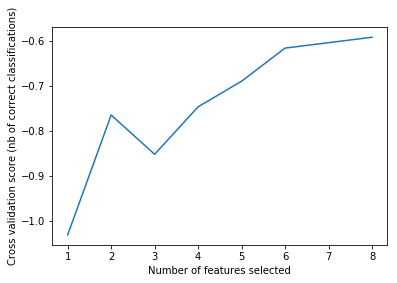

In [70]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR, SVC
estimator = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=3)
selector = RFECV(estimator, step=3, cv=2, scoring="neg_log_loss")
N=50
selector = selector.fit(X.iloc[:N], y.iloc[:N])
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [60]:
clf = utils.evaluate_model(X,y)
top_features = utils.feature_importances(clf, X.columns, n=20)

Log Loss
TRAIN: 0.49462200532678435
TEST: 0.5963065696711234

Accuracy
TRAIN: 0.8072519083969466
TEST: 0.6927480916030534

1: Feature: possible_matchups.PERCENT_TRUE(matchup_log.team_1_is_higher_seed), 0.052
2: Feature: team_1_seed_matchup, 0.037
3: Feature: team_1_is_higher_seed_matchup, 0.035
4: Feature: team.MEAN(team_game_log.opp_margin)_tgm_team, 0.031
5: Feature: team.MAX(team_game_log.team_seed)_tgm_team, 0.028
6: Feature: possible_matchups.SUM(matchup_log.team_1_seed), 0.026
7: Feature: team_2_seed_matchup, 0.024
8: Feature: possible_matchups.MIN(matchup_log.team_1_seed), 0.023
9: Feature: possible_matchups.MAX(matchup_log.team_2_seed), 0.021
10: Feature: team.SUM(team_game_log.opp_seed)_tgm_team, 0.018
11: Feature: possible_matchups.MIN(matchup_log.team_2_seed), 0.017
12: Feature: team.PERCENT_TRUE(team_game_log.team_is_higher_seed)_tgm_team, 0.016
13: Feature: possible_matchups.MAX(matchup_log.team_1_seed), 0.015
14: Feature: team.SUM(team_game_log.game_MOV)_tgm_team, 0.015
1

Let's rerun with the top 15 features

In [65]:
X,y = utils.transform_to_Xy(fm_encoded, tourney_labels, top_features)
utils.evaluate_features(X,y)
clf = utils.evaluate_model(X,y)
top_features = utils.feature_importances(clf, X.columns, n=20)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished


AUC 0.77 +/- 0.02
Log Loss
TRAIN: 0.4873537005620561
TEST: 0.5885939667710887

Accuracy
TRAIN: 0.7538167938931297
TEST: 0.6889312977099237

1: Feature: team_1_is_higher_seed_matchup, 0.115
2: Feature: team.MEAN(team_game_log.opp_margin)_tgm_team, 0.109
3: Feature: possible_matchups.PERCENT_TRUE(matchup_log.team_1_is_higher_seed), 0.093
4: Feature: team_1_seed_matchup, 0.075
5: Feature: team.SUM(team_game_log.opp_seed)_tgm_team, 0.074
6: Feature: team.MAX(team_game_log.team_seed)_tgm_team, 0.057
7: Feature: possible_matchups.MAX(matchup_log.team_1_seed), 0.054
8: Feature: team_2_seed_matchup, 0.052
9: Feature: possible_matchups.MAX(matchup_log.team_2_seed), 0.043
10: Feature: possible_matchups.MIN(matchup_log.team_2_seed), 0.041
11: Feature: possible_matchups.MIN(matchup_log.team_1_seed), 0.039
12: Feature: team.MEAN(team_game_log.game_MOV)_tgm_team, 0.038
13: Feature: team.SUM(team_game_log.game_MOV)_tgm_team, 0.035
14: Feature: possible_matchups.SUM(matchup_log.team_1_seed), 0.035
15:

I need to remove the duplicated seed information on the feature merge. 

Overall I think the features the model found are intuitive, they go along with defense wins championships, and frankly I was a little surprised the model was as accurate as it was with such a limited sample size per matchup.   
  
But moreso than defense wins championships, the feature importances reflect what you would expect from features like these. Winning is determined by beating the other team and noisier metrics like field goal attempts can happen.    
  
By using feature groupings like FGM/FGA and computing metrics like true shooting percent we can account for the situational nuances of the data. Play by play data offers more opportunity as well

# Submit to Kaggle

First we need to add an ID that follows Kaggle's format

In [48]:
tourney_labels['ID']=tourney_labels['game_index'].apply(utils.game_index_to_kaggle_id)
tourney_labels['Pred']=clf.predict_proba(X)[:,1]
tourney_labels

,game_index,time,team_1_wins,ID,Pred
0,2003_134_1411_1421,2003-03-18,False,2003_1411_1421,0.302018
1,2003_136_1112_1436,2003-03-20,True,2003_1112_1436,0.792137
2,2003_136_1113_1272,2003-03-20,True,2003_1113_1272,0.345710
...,...,...,...,...,...
1045,2018_152_1242_1437,2018-03-31,False,2018_1242_1437,0.537820
1046,2018_152_1260_1276,2018-03-31,False,2018_1260_1276,0.318646
1047,2018_154_1276_1437,2018-04-02,False,2018_1276_1437,0.425630


Now we merge with a dataframe of all possible matchups for Kaggle

In [49]:
possible_tourney_games_df=utils.build_possible_tourney_games()
predictions=possible_tourney_games_df.merge(tourney_labels,on=["ID"], how="left")
predictions['Pred']=predictions['Pred'].fillna(.5)
predictions

,Team1_ID,Team2_ID,Season,TeamID,ID,game_index,time,team_1_wins,Pred
0,1107,1110,2014,1107,2014_1107_1110,NaN,NaT,NaN,0.5
1,1107,1112,2014,1107,2014_1107_1112,NaN,NaT,NaN,0.5
2,1107,1113,2014,1107,2014_1107_1113,NaN,NaT,NaN,0.5
...,...,...,...,...,...,...,...,...,...
11387,1455,1460,2018,1455,2018_1455_1460,NaN,NaT,NaN,0.5
11388,1455,1462,2018,1455,2018_1455_1462,NaN,NaT,NaN,0.5
11389,1460,1462,2018,1460,2018_1460_1462,NaN,NaT,NaN,0.5


In [50]:
predictions[['ID','Pred']].to_csv("matchups_seeds_and_team_game_log.csv",index=False)

We're ready to submit to Kaggle! https://www.kaggle.com/c/mens-machine-learning-competition-2019/submit  
  
Our submission value should be similar to belows log-loss, with a small difference because we have a few play in games included in the prediction that Kaggle doesn't actually score)

In [51]:
kaggle_played_tourney_labels=utils.build_played_kaggle_labels(matchups_es, tourney_starts)
combined_labels=kaggle_played_tourney_labels.merge(tourney_labels, on="game_index", how="left", suffixes=["","_y"])
log_loss(combined_labels['team_1_wins'],combined_labels['Pred'].fillna(.5))

0.5590018176338849

In [77]:
predictions['Pred'].describe()

count    11390.000000
mean         0.499177
std          0.036958
             ...     
50%          0.500000
75%          0.500000
max          0.798980
Name: Pred, Length: 8, dtype: float64

This is not a great score on Kaggle. Only a small improvement from guessing 50% for each game. The best way to view this matchups_model is as a specialized model that provides information on matchup history when it exists. In the Kaggle submission we have a history based prediction for ~120 out of 335 predictions. Restricting that to teams that have played more than 3 in the last 5 years would reduce the number of informed predictions drastically

# Next Steps
Let me know your thoughts on everything as soon as you can. I think adding seeds would be a useful set of features and be pretty quick since I already have the ID computed in another notebook.    
  
For team_game_logs I need to switch the cutoff_time and may have some questions on that.  
  
Feature groupings could be very interesting but I'm not sure how much I will be able to do if we want to get the article out this weekend. (I think it would be ideal to have the article out by Sunday night in terms of people reading and sharing it but we would need to balance the how many things I can put into it with the time remaining).  
  
I think the article would still be highly relevant into the later rounds of the tournament and there could be a great buzz of interest from the analytics community in the mid-to-late rounds as people discuss the Elite eight final four and eventual champion as they watch their brackets closely. The Kaggle submission is due on Thursday 21st. Good early results could build article interest too.
  
